# TP2 Mean Shift

Read, understand, and complete and run the following notebook. You must return the completed notebook, including your answers and illustrations (you may need to add cells to write your code or comments). 

Return your work by e-mail using a single file (ipynb or zip) with the format 'introvis18_tp2_yourname.ipynb'


## 0. Imports

In [1]:
import numpy as np 
# this is the key library for manipulating arrays. Use the online ressources! http://www.numpy.org/

import matplotlib.pyplot as plt 
# used to read images, display and plot http://matplotlib.org/api/pyplot_api.html . 
#You can also check this simple intro to using ipython notebook with images https://matplotlib.org/users/image_tutorial.html

%matplotlib inline 
# to display directly in the notebook

import scipy.ndimage as ndimage
# one of several python libraries for image procession

plt.rcParams['image.cmap'] = 'gray' 
# by default, the grayscale images are displayed with the jet colormap: use grayscale instead

from skimage.color import rgb2lab,lab2rgb
# for colorspace conversions

import random

import time

___
___
## 1. Mean shift

<span style="color:lightgrey">In this section, we will implement Mean Shift and test is on simple synthetic data (i.e. points you will sample from a probability distribution with known density - see below).

**1: Generate a random vector of 100 2D points 'data1' with 50 points sampled from a Gaussian distribution of variance 1 centered in (0,0) and 50 points sampled from a Gaussian distribution of variance 1 centered in (2,1). Plot your points using the 'plt.scatter' function. This 'data' vector will be the synthetic data you will try to cluster, and for which the algorithm should manage to separate the point coming from each of the two Gaussians. Repeat to create a vector 'data2' with the center of the second Gaussian in (3,3). Which will be the easiest data vector to cluster? Test both in the following experiments.**

In [2]:
# random vector of 100 points with two 50 points gaussian distributions
def gauss_2d(mu, sigma):
    x = random.gauss(mu[0], sigma[0])
    y = random.gauss(mu[1], sigma[1])
    return [x, y]

def rdvec(mu1,sigma1,mu2,sigma2,n1=50,n2=50):
    X,x_1,x_2,data = [],[],[],[]

    for i in range(n1):
        x_1.append(gauss_2d(mu1,sigma1))
    for j in range(n2):
        x_2.append(gauss_2d(mu2,sigma2))

    X.append(x_1)
    X.append(x_2)

    X = np.array(X)
    
    data = np.vstack(X)
    
    return X,data

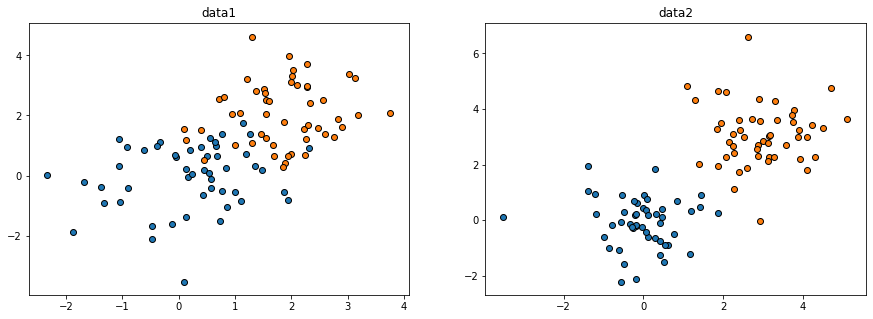

In [3]:
X1, data1 = rdvec([0,0],[1,1],[2,2],[1,1])
X2, data2 = rdvec([0,0],[1,1],[3,3],[1,1])


# plot (with one color for each distributionn)
fig = plt.figure(figsize = (15,5))

# data 1
plt.subplot(1, 2, 1)
for x in X1:
    plt.scatter(x[:,0],x[:,1],edgecolors='black') # scatter points
plt.title("data1")

# data 2
plt.subplot(1, 2, 2)
for x in X2:
    plt.scatter(x[:,0],x[:,1],edgecolors='black') # scatter points
plt.title("data2")

# show plot
plt.show()

The easier vector to cluster should be `data2` since the distributions are further apart from each other (so less superimposed points)

___
**2: We will segment images using a different distance parameter for space and color. For this reason, we will use a d dimensionnal vector 'sigma' as a parameter for all our mean-shift functions. It defines a scale for each dimension. What would be a meaningful parameter sigma for each of the synthetic data sets (data1 and data2)?**

The smaller sigma is, the more modes it finds (it can end up not being very useful, if we are trying to modelize simple situations). On the contrary, when sigma is large, it agregates points together more easily and can quickly collapse into one mode.

For data1, a sigma bigger than 0.8 seems to collapse all the updated positions into one "blurb", which will be a bad thing when we want to compute modes. When it is smaller than 0.6, the change is very small. We can confortably pick a value between 0.6 and 0.8.

For data2, we can pick a value between 0.6 and 1 (to have usefull values). 

A compromise (for testing future functions for both at the same time) can be 0.7

___
**3: Implement the function MS_step which takes as input a vector of all the data point 'data', a starting point 'x' and the standard deviations 'sigma' and returns the updated position of the point 'x' after one step of the mean-shift algorithm. Test it on your synthetic data and visualize the result.**

<span style="color:lightgrey">Be cautious: the formula in the lecture are mostly in the isotropic case. In the anisotropic case, you can either redo the derivation, or simply scale the components to come back to the isotropic case.

we will be using the approach described in the following papers:

 - <div class="csl-bib-body" style="line-height: 2; margin-left: 2em; text-indent:-2em;">
  <div class="csl-entry">Comaniciu, D., and P. Meer. “Mean Shift: A Robust Approach toward Feature Space Analysis.” <i>IEEE Transactions on Pattern Analysis and Machine Intelligence</i>, vol. 24, no. 5, May 2002, pp. 603–19. <i>DOI.org (Crossref)</i>, doi:10.1109/34.1000236.</div>
</div>
 - <div class="csl-bib-body" style="line-height: 2; margin-left: 2em; text-indent:-2em;">
  <div class="csl-entry">Bugeau, Aurelie, and Patrick Pérez. “Bandwidth Selection for Kernel Estimation in Mixed Multi-Dimensional Spaces.” <i>ArXiv:0709.1920 [Cs]</i>, Sept. 2007. <i>arXiv.org</i>, http://arxiv.org/abs/0709.1920.</div>
</div>

Our objective, in MS_step, is to compute $m(x) = \frac{\sum x_i exp(-\frac{1}{2}|| \frac{(x-x_i)}{H}|| )}{\sum exp(-\frac{1}{2}|| \frac{(x-x_i)}{H}|| )} - x$ for a given x

Since we want to visualize the result afterwords, it is easier to superimpose the difference between each point and its new position, so we will also output $m(x) - x$ = mx_lambda (it will be the default value)

We start with the kernel density estimator: $\hat{f}_h(x) = \frac{1}{n} \sum_{i=1}^{n} K_H(x-x_i)$

where $K_H(x) = \frac{1}{H^{1/2}} K(\frac{x}{H^{1/2}})$ is the kernel and $H$ the bandwidth. We can consider the bandwidth as a matrix corresponding to the square of the diagonalization of sigma (as seen in the first paper).

we want a kernel profile such that $K(x)$ integrates to one: let's find $K(x) =  c_k k(||x||^2)$, with $c_k$ a normalization constant. In our case, we are looking for a Gaussian  kernel

we can rewrite $\hat{f}(x)$: $= \frac{c_k}{n|H|^{1/2}} \sum_{i=1}^{n} k(||\frac{x-x_i}{H^{1/2}}||)$ with $k(x)$ being a kernel defined by the profile: $k(x) = exp(-\frac{1}{2}x)$.

we have $g(x) = -k^{'}(x) = -\frac{1}{2}k(x)$, so we obtain the normalization $c_k = \frac{1}{\sqrt{(2\pi)^{d}}}$, with d the dimension of $\sigma$

we can rewrite $m(x)$: $= \frac{\sum x_i g(|| \frac{(x-x_i)}{H}|| )}{\sum g(|| \frac{(x-x_i)}{H}|| )} - x$ with $g(x)$ as defined previously

To compute $m(x)$, we first want to compute the norm $|| \frac{(x-x_i)}{H}||$, that gives the distance between the point x to all other points. For that purpose, we implement a function `norm(x,X)` that given a point $x$ and a set of points $X$, will iterate over them and return the distances to each one of them normalized by $H$.

we can then implement the functions `k(x)` and `g(x)`, not forgetting to normalize by $c_k$, and finally compute $m(x)$

In [4]:
def MS_step(data, x, sigma, display = True):
    d = sigma.shape # dimension
    bandwidth = np.diag(sigma)**2 # bandwidth matrix
    
    #------------------------------------------------------#
    def norm(x,X):
        return (np.sqrt((x-X)**2).dot(np.linalg.inv(bandwidth))).sum(1)
    
    def k(x):
        return np.exp((-1/2)*x)
    
    def g(x): # g(x) = -k'(x) = -(1/2)k(x)
        return (-1/2)*k(x)
    
    c = 1/(np.sqrt(2*np.pi)**d) # normalization for g(x)
    #------------------------------------------------------#
    
    coef = c * g(norm(x,data))
    
    mx = data.T.dot(coef)/np.sum(coef) + x
    mx_lambda = data.T.dot(coef)/np.sum(coef)
    
    return mx_lambda if display else mx

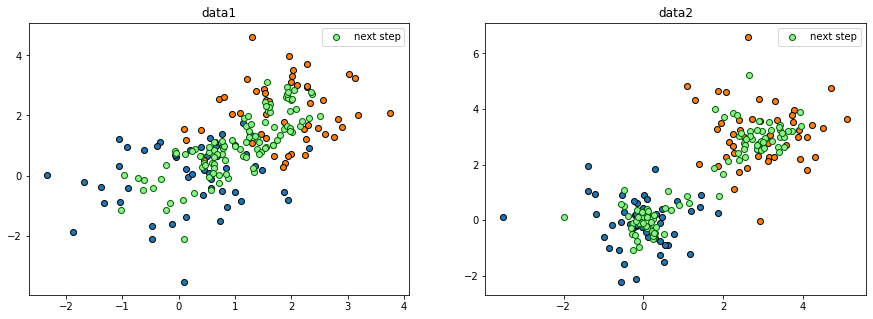

In [5]:
sigma = np.array([0.7,0.7])

# plot (with one color for each distributionn)
fig = plt.figure(figsize = (15,5))

# data 1
plt.subplot(1, 2, 1)
for x in X1:
    plt.scatter(x[:,0],x[:,1],edgecolors='black') # scatter points
next_step = np.apply_along_axis(lambda x: MS_step(data1, x, sigma), 1,
                                data1) # get points after MS_step
plt.scatter(next_step[:,0], next_step[:,1], edgecolors='darkgreen',
            color='lightgreen', label="next step") # scatter them
plt.legend() 
plt.title("data1")

# data 2
plt.subplot(1, 2, 2)
for x in X2:
    plt.scatter(x[:,0],x[:,1],edgecolors='black') # scatter points
next_step_2 = np.apply_along_axis(lambda x: MS_step(data2, x, sigma), 1, 
                                  data2) # get points after MS_step
plt.scatter(next_step_2[:,0], next_step_2[:,1], edgecolors='darkgreen',
            color='lightgreen', label="next step") # scatter them
plt.legend()
plt.title("data2")

# show plot
plt.show()

___
**4: Implement the function MS_point which iterates MS_step until convergence (e.g. the estimate changes by less than 0.01). Test it on your synthetic data and visualize the results.**

In [6]:
def MS_point(data,x,sigma,p=0.01):
    
    while np.linalg.norm(x-MS_step(data,x,sigma))>p: # do MS_step until delta<p
        x = MS_step(data,x,sigma)
    
    return x

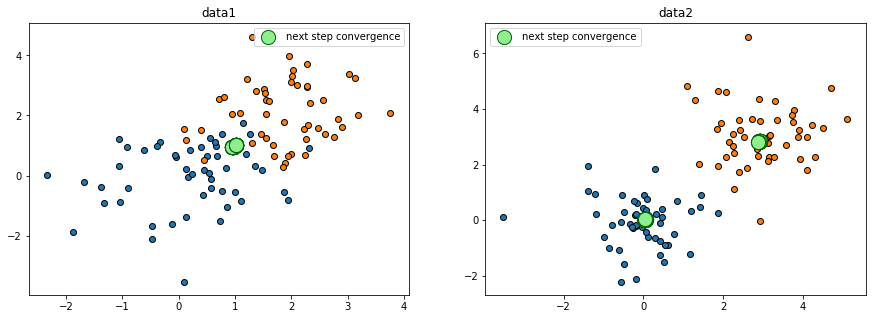

In [7]:
sigma = np.array([0.7,0.7])

# plot (with one color for each distributionn)
fig = plt.figure(figsize = (15,5))

# data 1
plt.subplot(1, 2, 1)
for x in X1:
    plt.scatter(x[:,0],x[:,1],edgecolors='black') # scatter points
next_step_conv = np.apply_along_axis(lambda x: MS_point(data1, x, sigma), 1,
                                     data1) # get points after MS_step
plt.scatter(next_step_conv[:,0], next_step_conv[:,1], s=200, edgecolors='darkgreen',
            color='lightgreen', label="next step convergence") # scatter them
plt.legend() 
plt.title("data1")

# data 2
plt.subplot(1, 2, 2)
for x in X2:
    plt.scatter(x[:,0],x[:,1],edgecolors='black') # scatter points
next_step_conv_2 = np.apply_along_axis(lambda x: MS_point(data2, x, sigma), 1,
                                       data2) # get points after MS_step
plt.scatter(next_step_conv_2[:,0], next_step_conv_2[:,1], s=200, edgecolors='darkgreen',
            color='lightgreen', label="next step convergence") # scatter them
plt.legend()
plt.title("data2")

# show plot
plt.show()

___
**5: Implement the MS function, which implements the full mean shift algorithm by iterating MS_point on all the points, and merging modes which distance normalized by sigma $\sqrt{\sum((\frac{x-y}{\sigma})^{2}) }$ is smaller than 0.5 . It must return a list of the modes and a label (corresponding to a mode) for each point.**

straight forward function. I also implement a mean parameter, that allows to compute the mean value for a given mode, instead of arbitrarily setting the value for the mode according to that of the point that first created it.

In [8]:
def MS(data,sigma,tolerance = 0.5,mean = True):
    
    def find_modes(data,sigma,tolerance):
        modes,modes_values,labels = [],[],[]
        
        for i,d in enumerate(data):
            # initialize first mode with first MS_point value
            if i ==  0:
                modes.append([0,MS_point(data,data[0],sigma)])
                modes_values.append([0,0,MS_point(data,data[0],sigma)])
                labels.append([0])
                nb_modes = 1
                continue
                
            pt = MS_point(data,d,sigma)
            found_mode = False
            
            for j,m in modes:
                if np.linalg.norm((pt-m)/sigma) <= tolerance:
                    labels.append([j])
                    modes_values.append([i,j,MS_point(data,d,sigma)])
                    found_mode = True
                    break # for if two modes are closer than the tolerance (small sigmas...)
            
            if not found_mode: 
                modes.append([nb_modes,MS_point(data,d,sigma)])
                modes_values.append([i,nb_modes,MS_point(data,d,sigma)])
                labels.append([nb_modes])
                nb_modes += 1
            
            if len(labels) > data.shape[0]:
                print("there was a problem in iteration", i) # for debugging (break...)
        
        return np.vstack(np.array(modes)), modes_values, np.array(labels)
    
    
    def mean_mode(modes,modes_values):
        nb_modes = modes[modes.shape[0]-1][0]+1
        value_dim = modes_values[0][2].shape[0]
        
        values = np.zeros((nb_modes,value_dim))
        nb_values_mod = np.zeros(nb_modes)
        mean_mod = []
        
        for val in modes_values:
            for mod in range(nb_modes):
                if val[1] == mod:
                    values[mod] += val[2]
                    nb_values_mod[mod]+=1
        
        for mod_i in range(nb_modes):
            mean_mod.append([values[mod_i][j] / int(nb_values_mod[mod_i]) 
                             for j in range(value_dim)])
        
        mean_mod = np.array(mean_mod)
        
        return mean_mod

    modes_ind, modes_values, labels = find_modes(data,sigma,tolerance)
    
    mean_modes = mean_mode(modes_ind,modes_values)
    
    modes = np.vstack(modes_ind[:,1]) # just keep position information
        
    
    return (labels, mean_modes) if mean else (labels, modes)

In [10]:
sigma = np.array([0.6,0.6])

labels,modes = MS(data2,sigma)
nb_modes = np.zeros((len(modes),1))
for i in range(len(data2)):
    for j in range(len(modes)):
        if labels[i][0] == j:
            nb_modes[j] += 1
            
for it,(i,j) in enumerate(zip(modes, nb_modes)):
    print("mode",it,", centered in position",str(i),", has",int(j),"points")

mode 0 , centered in position [-0.02238969  0.00368429] , has 51 points
mode 1 , centered in position [2.95244821 2.85655373] , has 49 points


___
___
## 2. Segmentation

**1: Download [this small image](http://imagine.enpc.fr/~aubrym/lectures/introvis17/legumes_small.jpg), load it and convert it to the Lab colorspace. Why is it necessary to change colorspace? What are the range of the colorvalues in Lab?**

(62, 50, 3)


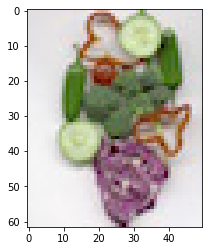

In [11]:
img_lab = rgb2lab(plt.imread('legumes_small.jpg'))
print(img_lab.shape)
plt.imshow(plt.imread('legumes_small.jpg'))
plt.show()

in RGB colorspace, two colors tham seem to be visually similar have totally different values. The Lab colorspace was made to make visually similar colors close in the colorspace.

Lab colorspace:
 - Luminance: $[0,100]$
 - Green-Red: $[-127,128]$
 - Blue-Yellow: $[-128,127]$

___
**2: In Mean Shift segmentation, all pixels in the image will be treated as data points including both their color and position in the image. Convert the (N,M,3) image into an (NM,5) array incuding color and position information for each point. What would be a meaningful value for sigma?**

<span style="color:lightgrey">Tip: use the np.meshgrid function

In [12]:
# convert (N,M,3) into (NM,5)
def nm5(img_lab):
    xx, yy = np.meshgrid(np.arange(img_lab.shape[1]), 
                         np.arange(img_lab.shape[0])) # retrieve position information
    
    img_pos = np.concatenate((img_lab, yy[:,:,None], 
                              xx[:,:,None]), axis=2) # add two dimensions with position information

    img_NM5 = np.reshape(img_pos, [-1, 5]) # flatten
    
    return img_NM5

It is difficult to find a meaningful value for sigma for several reasons. First and foremost, it is difficult to define how many modes we want at the end: do we want a schematic view (with few modes) or a more detailed segmentation? We could build an iterative function that would find values of sigma that result in a certain number of modes. But that would be impractical, since we have 5 different values of sigma, one for each dimension.

In the 2D example seen above, there seems to be sweetspot for sigma (where it gives only two modes, doesn't colapse to one mode, and seems to have a good precision) between 0.5 and 0.9. Outside this range the function doesn't find two modes (only one when it is under 0.5, and several when over 0.9). Let's try to manually find a value for sigma that seems coherent.

___
**3: Use the MS function from the previous section to compute a meaningful segmentation of the image. Visualize the results as an image by replacing the color values of the pixels associated to each mode by the color of the mode.**

In [14]:
def segmentation(img_lab,sigma,mean=True):
    img_NM5 = nm5(img_lab)
    
    # compute modes and labels (and time it, can be long...)
    start = time.time()
    labels, modes = MS(img_NM5,sigma,mean)
    end = time.time()
    
    print(end-start,"seconds")
    print("The segmentation creates",len(modes),"modes")
    
    # labels -> color
    pts_mod = labels.tolist() # point -> mode
    pts_col = [] # point -> color (in Lab format)
    
    for mod in pts_mod:
        pts_col.append(modes[int(mod[0])][:3]) # append only L, a and b values
    
    seg_img = lab2rgb(np.reshape(np.array(pts_col), img_lab.shape)) # nm5 -> img_Lab -> img_rgb
    
    return seg_img

234.67291402816772 seconds
The segmentation creates 28 modes


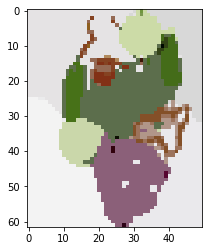

In [16]:
sigma = np.array([1.6,1.6,1.6,1.6,1.6])
plt.imshow(segmentation(img_lab,sigma))